In [1]:
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d
import numpy as np
from miditoolkit.pianoroll import parser as pr_parser
from miditoolkit.pianoroll import utils
import matplotlib.pyplot as plt

In [2]:
# helper functions
def read_midi(path):
    DEFAULT_RESOLUTION=24
    mido_obj = mid_parser.MidiFile(path)
    tick_per_beat = mido_obj.ticks_per_beat

    notes = [] 
    for instrument in mido_obj.instruments:
        for note in instrument.notes:
            #rescale tpb to 480
            note.start = int(note.start/tick_per_beat*DEFAULT_RESOLUTION)
            note.end=int(note.end/tick_per_beat*DEFAULT_RESOLUTION)
            notes.append(note)

    # sort by start time
    notes.sort(key=lambda note:note.start)
    return notes,24

def write_midi(notes,path='out.mid',tick_per_beat=480):
    out = mid_parser.MidiFile()
    out.ticks_per_beat = tick_per_beat
    out.instruments = [ct.Instrument(program=0,is_drum=False,name='right hand'),ct.Instrument(program=0,is_drum=False,name='left hand')]
    
    for note in notes:
        assert(note.velocity)
        current_beat=note.start//tick_per_beat
        centers = centers_per_beat[current_beat]
        closest_center,abs_distance_to_centers = cluster_assignment(note, centers_per_beat, tick_per_beat,single_note=True)
        if(closest_center==0):
            out.instruments[1].notes.append(ct.Note(start=note.start,end=note.end,pitch=note.pitch,velocity=note.velocity))
        else:
            out.instruments[0].notes.append(ct.Note(start=note.start,end=note.end,pitch=note.pitch,velocity=note.velocity))
    out.dump(path)

def find_note_idx_before(notes, tick_per_beat, beat):
    # binary search
    target = beat*tick_per_beat-1
    left=0
    right=len(notes)-1
    middle=(left+right+1)//2
    while left<right:
        if notes[middle].start == target:
            if notes[middle+1].start==target:
                left=middle+1
            else:
                break
        elif notes[middle].start<target:
            left=middle
        else:
            right=middle-1
        middle=(left+right+1)//2
    return middle

def get_centers_per_beat(notes, tick_per_beat,kernel_size=5):
    # find centers
    centers_per_beat=[]

    ahead=1
    after=1

    start=ahead
    end=(notes[-1].start//tick_per_beat - after) +1

    trace_start_idx=0
    pitch_range = linspace(0,127)
    for beat in range(start,end):
        notes_within_window = notes[trace_start_idx:find_note_idx_before(notes, tick_per_beat, beat+after+1)+1]
        pitches_within_window = np.array([note.pitch for note in notes_within_window])

        # use KDE for clustering(intervaling)(determine the center line for left/right hand respectively)
        pitches_within_window = pitches_within_window.reshape(-1,1)
        kernel_size=6
        #interatve clustering
        while True:
            kde = KernelDensity(kernel='gaussian', bandwidth=kernel_size).fit(pitches_within_window)
            kde_val = kde.score_samples(pitch_range.reshape(-1,1))
            # visualization: distribution of notes inside the window
            # plot(pitch_range, kde_val)
            minima, maxima = argrelextrema(kde_val, np.less)[0], argrelextrema(kde_val, np.greater)[0]
            
            #termination check
            if len(minima)>=1 and len(maxima)>=2:
                # cluster selection
                cutoff=min(pitch_range[minima])
                cluster_1_candidate = pitch_range[ maxima[pitch_range[maxima]<cutoff] ]
                cluster_2_candidate = pitch_range[ maxima[pitch_range[maxima]>cutoff] ]
                assert(len(cluster_1_candidate)>=1)
                assert(len(cluster_2_candidate)>=1)
                clusters= sorted([round(max(cluster_1_candidate)), round(max(cluster_2_candidate))])
                centers_per_beat.append(clusters)
                break
                
            elif kernel_size<0.001:
                #probably only one hand is needed
                centers_per_beat.append([round(np.average(pitches_within_window)),round(np.average(pitches_within_window))])
                break
            
            else:
                kernel_size*=0.7
                
                continue
                

    # padding for start and end
    centers_per_beat = ([centers_per_beat[0]]*ahead) + centers_per_beat + ([centers_per_beat[-1]]*after)
    centers_per_beat = np.array(centers_per_beat)
    
    #smooth the line
    centers_per_beat[:,0]=gaussian_filter1d(centers_per_beat[:,0], kernel_size)
    centers_per_beat[:,1]=gaussian_filter1d(centers_per_beat[:,1], kernel_size)
    return np.array(centers_per_beat)

def cluster_assignment(notes, centers_per_beat, tick_per_beat, single_note=False):
    def center_ordering(centers_per_beat):
        # make sure the cluster with lower octave stay at index 0 (left hand)
        for center in centers_per_beat:
            if center[0]>center[1]:
                return False
        else:
            return True
    def assignment(note):
        current_beat=note.start//tick_per_beat
        centers = centers_per_beat[current_beat]
        abs_distance_to_centers=abs(note.pitch - centers)
        closest_center=np.argmin(abs_distance_to_centers)
        return closest_center,abs_distance_to_centers
    
    
    assert(center_ordering(centers_per_beat))
    if single_note == True:
        #return idx of cluster (0:left, 1:right)
        return assignment(notes)
    
    else:
        classified=[[],[]]
        abs_distance_to_classified_centers=[[],[]]
        for note in notes:
            closest_center,abs_distance_to_centers = assignment(note)
            classified[closest_center].append(note)
            abs_distance_to_classified_centers[closest_center].append(abs_distance_to_centers)            
        return classified,abs_distance_to_classified_centers

In [3]:
# filter long duration notes
def trim_long_notes(notes, tick_per_beat):
    def trim(note):
        if note.end-note.start>threshold*tick_per_beat:
            note.end = note.start+threshold*tick_per_beat
        return note
    
    threshold=4
    return list(map(trim, notes))

In [4]:
def octave_transpose(transpose_notes, tick_per_beat,threshold=10,center_threshold=5):
    # octave transpose
    # for simplicity, use semitone instead of octave
    max_semitone_distance=threshold

    centers_per_beat = get_centers_per_beat(transpose_notes, tick_per_beat,center_threshold)
    transpose_track=[]
    skip_track=[]
    count=0
    skip_count=0

    for note_idx,note in enumerate(transpose_notes):
        # cluster assignment
        current_beat=note.start//tick_per_beat
        centers = centers_per_beat[current_beat]
        closest_center,abs_distance_to_centers = cluster_assignment(note, centers_per_beat, tick_per_beat,single_note=True)

        if abs_distance_to_centers[closest_center]>max_semitone_distance:
            # transpose
            if note.pitch>centers[closest_center]:
                # transpose downward 
                # skip right hand first
                # TODO: later figure out how to avoid transposing melody's note
                if closest_center==0: 
                    transpose_notes[note_idx].pitch-=12*( ((abs_distance_to_centers[closest_center]-max_semitone_distance)//12) +1)
                    count+=1
                else:
                    skip_count+=1
            else:
                # transpose upward
                transpose_notes[note_idx].pitch+=12*( ((abs_distance_to_centers[closest_center]-max_semitone_distance)//12) +1)
                count+=1
    
    # visualization : center line of left/right hand
    print('Octave Transpose:','#notes',len(transpose_notes),'transposed',count,'notes',', skipped',skip_count)
    #plot(centers_per_beat)
    
    return transpose_notes,centers_per_beat

In [5]:
def doubling_simplification(notes,centers_per_beat, tick_per_beat):
    notes = np.array(notes)
    count=0
    track_tick=0
    track_idx=0
    collections=[]
    delete=[]
    threshold=3
    while track_idx<len(notes):
        if notes[track_idx].start==track_tick:
            # gathering notes start at the same tick
            collections.append(notes[track_idx])
            track_idx+=1
        else:
            # action
            classified,abs_distance_to_classified_centers = cluster_assignment(collections,centers_per_beat, tick_per_beat)
            keep=[[None for _ in range(12)] for __ in range(2)]
            # doubling simplification on different hand separately
            for group in range(2):
                note_count=0
                delete_candidates=[]
                for note in classified[group]:
                    if keep[group][note.pitch%12] is None:
                        keep[group][note.pitch%12] = note
                    elif keep[group][note.pitch%12].pitch>=note.pitch:
                        delete_candidates.append(note)
                    else:
                        delete_candidates.append(keep[group][note.pitch%12])
                        keep[group][note.pitch%12]=note
                    note_count+=1
                if note_count>threshold:
                    #remove doubling
                    delete_count = note_count-threshold
                    delete_candidates.sort(key=lambda x:x.pitch)
                    delete_candidates = delete_candidates[0:delete_count]
                    for note in delete_candidates:
                        delete.append(note)
            # reset
            collections=[notes[track_idx]]
            track_tick=notes[track_idx].start
            track_idx+=1
            
    for note in delete:
        notes = np.delete(notes, np.where(notes == note)[0])
        count+=1
            
    print('Doubling Simplification:','removed doubling',count)
    return notes


In [6]:
def merge_discrete_note(notes):
    org_len=len(notes)
    #profile
    all_pitch={}
    for note in notes:
        pitch=note.pitch
        if pitch in all_pitch:
            all_pitch[pitch].append(note)
        else:
            all_pitch[pitch]=[note]
    #merge
    for k,v in all_pitch.items():
        trace_idx=0
        while trace_idx<len(v)-1:
            if v[trace_idx+1].start-v[trace_idx].end<=merge_threshold:
                v[trace_idx].end=v[trace_idx+1].end
                v.pop(trace_idx+1)
            else:
                trace_idx+=1
    #output
    notes=[]
    for k,v in all_pitch.items():
        for note in v:
            notes.append(note)
    notes.sort(key=lambda note:note.start)      
    filtered_len=len(notes)
    print('Merge discrete:','merged ',org_len-filtered_len,' discrete notes')
    return notes

In [7]:
def drop_discrete_note(notes):
    org_len=len(notes)
    
    new_notes=[]
    for note in notes:
        if note.end-note.start > discrete_note_threshold:
            new_notes.append(note)
    notes=new_notes        
    print('Drop discrete:','dropped ',org_len-len(notes),' discrete notes')
    return notes

In [8]:
def visualize(notes,centers_per_beat,tick_per_beat):
    assert(tick_per_beat==24)
    
    notes=sorted(notes,key=lambda note:note.start)
    pianoroll = pr_parser.notes2pianoroll(
                                notes, 
                                ticks_per_beat=tick_per_beat,
                                binary_thres=1
                                )
    pianoroll = pianoroll*1
    plt.figure(figsize = (20,20))
    plt.imshow(pianoroll.T, origin='lower')
    plt.plot(np.repeat(centers_per_beat[:, [1, 0]],tick_per_beat , axis=0))
    plt.legend(['Right hand','Left hand'])
    plt.show()

before post-processing 11732 notes
Octave Transpose: #notes 11732 transposed 1611 notes , skipped 503
Merge discrete: merged  6574  discrete notes
Drop discrete: dropped  938  discrete notes
Doubling Simplification: removed doubling 89
after post-processing, total notes: 4131, removed 7601 notes in total


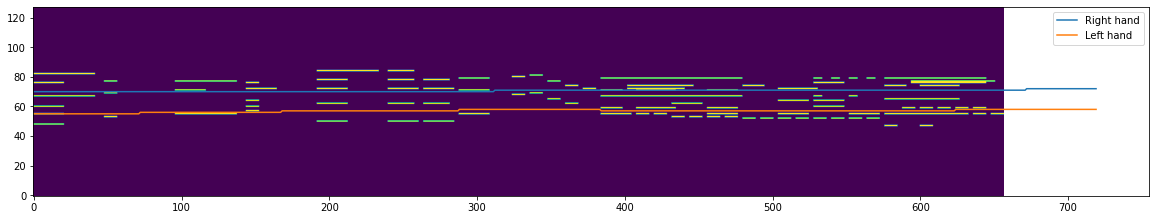

before post-processing 3846 notes
Octave Transpose: #notes 3846 transposed 405 notes , skipped 418
Merge discrete: merged  34  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 4
after post-processing, total notes: 3808, removed 38 notes in total


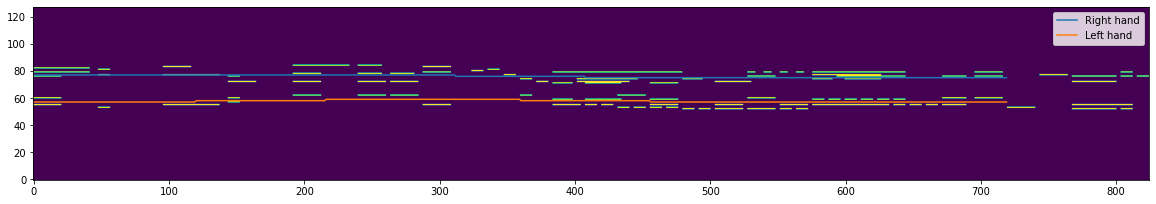

before post-processing 3808 notes
Octave Transpose: #notes 3808 transposed 390 notes , skipped 394
Merge discrete: merged  27  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 0
after post-processing, total notes: 3781, removed 27 notes in total


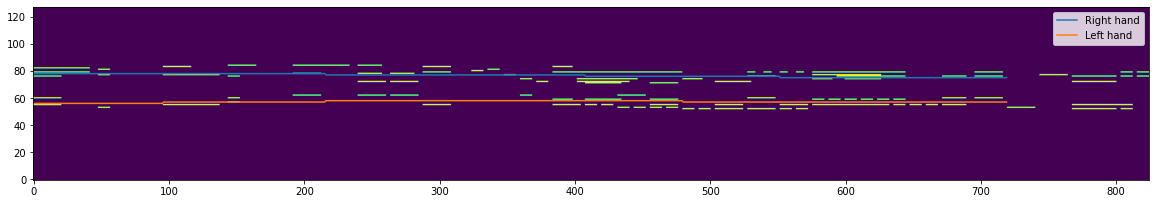

before post-processing 3781 notes
Octave Transpose: #notes 3781 transposed 516 notes , skipped 393
Merge discrete: merged  13  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 0
after post-processing, total notes: 3768, removed 13 notes in total


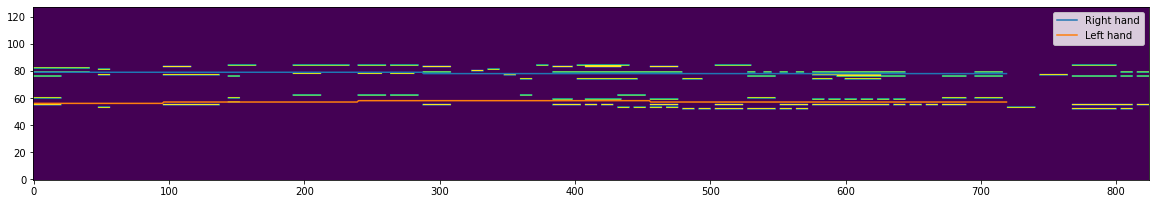

before post-processing 3768 notes
Octave Transpose: #notes 3768 transposed 899 notes , skipped 193
Merge discrete: merged  78  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 0
after post-processing, total notes: 3690, removed 78 notes in total


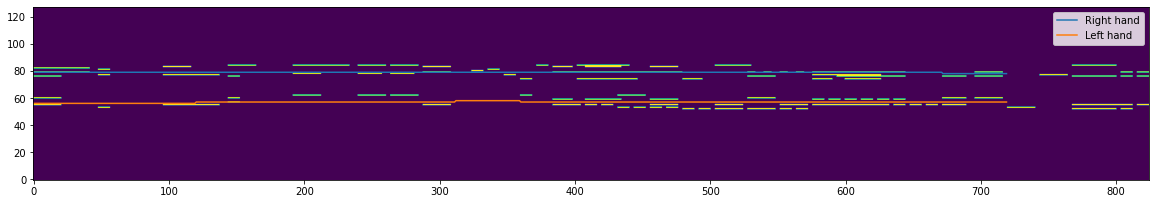

before post-processing 3690 notes
Octave Transpose: #notes 3690 transposed 614 notes , skipped 125
Merge discrete: merged  28  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 0
after post-processing, total notes: 3662, removed 28 notes in total


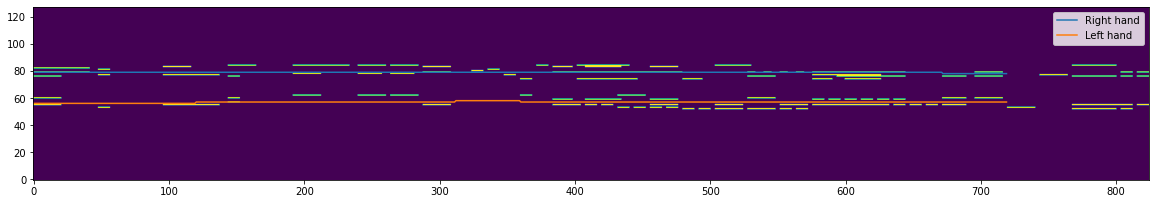

before post-processing 3662 notes
Octave Transpose: #notes 3662 transposed 405 notes , skipped 276
Merge discrete: merged  0  discrete notes
Drop discrete: dropped  0  discrete notes
Doubling Simplification: removed doubling 0
after post-processing, total notes: 3662, removed 0 notes in total


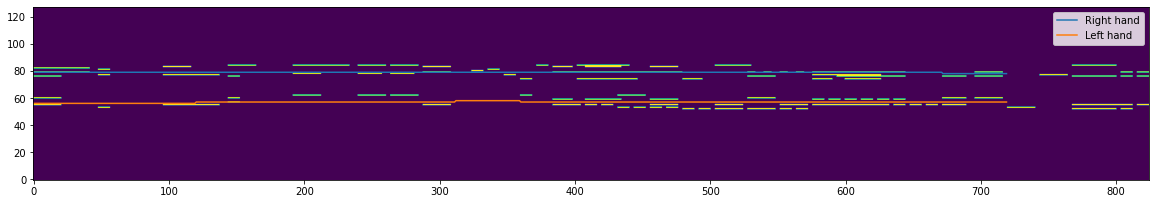

In [9]:
# main
merge_threshold=2 #minimum separation between notes in same pitch
discrete_note_threshold=5 #minimum length of a note

notes,tick_per_beat = read_midi("reduction.mid")
org_notes=len(notes)
print(f'before post-processing {org_notes} notes')
notes = trim_long_notes(notes, tick_per_beat)
notes,centers_per_beat = octave_transpose(notes, tick_per_beat)
notes = merge_discrete_note(notes)
notes = drop_discrete_note(notes)
notes = doubling_simplification(notes,centers_per_beat, tick_per_beat)
cur_notes=len(notes)
print(f'after post-processing, total notes: {cur_notes}, removed {org_notes-cur_notes} notes in total')
visualize(notes[:100],centers_per_beat[:30],tick_per_beat)


while True:
    notes,tick_per_beat = read_midi("post_processed.mid")
    org_notes=len(notes)
    print(f'before post-processing {org_notes} notes')
    notes = trim_long_notes(notes, tick_per_beat)
    notes,centers_per_beat = octave_transpose(notes, tick_per_beat,5,2)
    notes = merge_discrete_note(notes)
    notes = drop_discrete_note(notes)
    notes = doubling_simplification(notes,centers_per_beat, tick_per_beat)
    cur_notes=len(notes)
    print(f'after post-processing, total notes: {cur_notes}, removed {org_notes-cur_notes} notes in total')
    visualize(notes[:100],centers_per_beat[:30],tick_per_beat)
    write_midi(notes, "post_processed.mid", tick_per_beat)
    
    #termination
    if org_notes-cur_notes<10:        
        break